#**Final submission-SARIMA forecast**

In [1]:
# It is recommended to upgrade the statsmodels library. 
# Uncomment the below code to upgrade statsmodels
!pip install statsmodels --upgrade

In [2]:
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
#to ignore warnings
import warnings
import itertools
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel('MER_T12_06.xlsx')
df.head()

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions


In [5]:
#conversion of "YYYYMM" columnn into standard datetime format & making it as index
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_excel('MER_T12_06.xlsx', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df.head()

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions


**The arguments can be explained as:**

- **parse_dates:** This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
- **index_col:** This is a key that forces pandas to use the date time column as index.
- **date_parser:** Converts an input string into datetime variable.

# Exploratory Data Analysis

- Let us first identify and **drop the non datetimeindex** rows. First, let's convert the index to datetime, coerce errors, and filter NaT

In [6]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head()
ts.describe().T

,count,unique,top,freq
MSN,4707,9,CLEIEUS,523
Value,4707,3284,Not Available,384
Description,4707,9,Coal Electric Power Sector CO2 Emissions,523


**Observations**
1. The observations have reduced to 4707 after filtering on NaT
2. There are 9 unique categories in MSN and Description columns
3. The 'Value' coulmn has missing values with a high frequency of 384. The rows with these missing values should be eliminated

In [7]:
#convert the emision value into numeric value
nat=pd.DataFrame(pd.to_numeric(ts['Value'],errors='coerce')).convert_dtypes()
ts['Value']=nat['Value']

In [8]:
#Drop the missing value using dropna(inplace = True)
ts.dropna(inplace = True)
ts.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,4323.0,39.252449,61.128676,0.009,0.73,6.236,40.638,247.995


In [9]:
ts.dtypes

MSN             object
Value          Float64
Description     object
dtype: object

### **Natural gas based CO2 emission forecasting**

For developing the time series model and forecasting, you are expected to use the natural gas CO2 emission from the electrical power generation. We need to slice this data:

In [10]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector
natural=ts[ts['MSN']=='NNEIEUS']
natural= pd.DataFrame(natural).drop(['Description','MSN'],axis=1)

In [11]:
 #Check 1st few rows of data
natural.head()

,Value
YYYYMM,
1973-01-01,12.175
1973-02-01,11.708
1973-03-01,13.994
1973-04-01,14.627
1973-05-01,17.344


# **Split the dataset**

In [12]:
# Split the data into train and test
# using first 41 years data as training data
train_data = natural.loc['1973-01-01':'2014-01-01']

# using the last 2 years data as test data
test_data = natural.loc['2014-01-01':'2016-07-01']
print(train_data)
print(test_data)

             Value
YYYYMM            
1973-01-01  12.175
1973-02-01  11.708
1973-03-01  13.994
1973-04-01  14.627
1973-05-01  17.344
...            ...
2013-09-01  40.751
2013-10-01  34.547
2013-11-01  32.614
2013-12-01  36.308
2014-01-01  36.133

[493 rows x 1 columns]
             Value
YYYYMM            
2014-01-01  36.133
2014-02-01  30.036
2014-03-01  30.554
2014-04-01  29.885
2014-05-01  35.211
2014-06-01  39.228
2014-07-01  45.901
2014-08-01  48.871
2014-09-01  41.961
2014-10-01  38.286
2014-11-01  32.703
2014-12-01    34.8
2015-01-01  39.155
2015-02-01  35.668
2015-03-01  38.872
2015-04-01   36.61
2015-05-01   40.44
2015-06-01   48.92
2015-07-01  57.712
2015-08-01  56.662
2015-09-01  49.384
2015-10-01   43.68
2015-11-01  40.394
2015-12-01   42.27
2016-01-01  42.566
2016-02-01  37.918
2016-03-01  40.525
2016-04-01  39.763
2016-05-01   44.21
2016-06-01  53.567
2016-07-01  62.881


###**Test the Stationarity**

In [13]:
#Import the required package

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

###**Test the stationarity through Visualization**

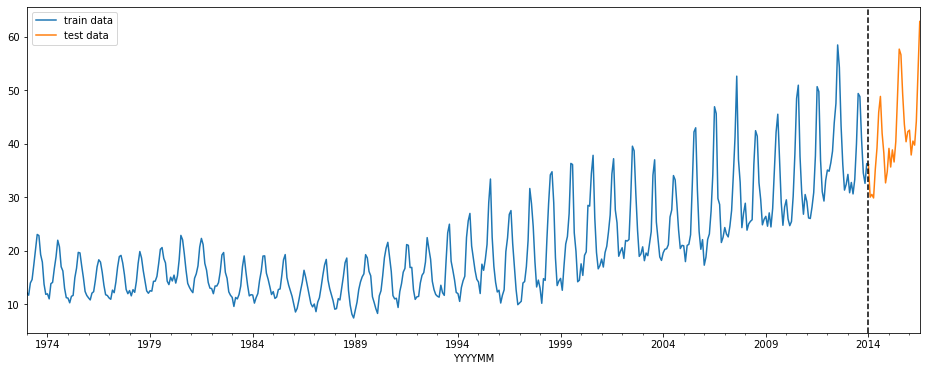

In [14]:
# creating a subplot space
fig, ax = plt.subplots(figsize=(16, 6))

# plotting train data
train_data.plot(ax=ax)

# plotting test data
test_data.plot(ax=ax)

# adding the legends in sequential order
plt.legend(['train data', 'test data'])

# showing the time which divides the original data into train and test
plt.axvline(x='2014-01-01', color='black', linestyle='--')

# showing the plot
plt.show()
fig.savefig("series", bbox_inches='tight', dpi=600)

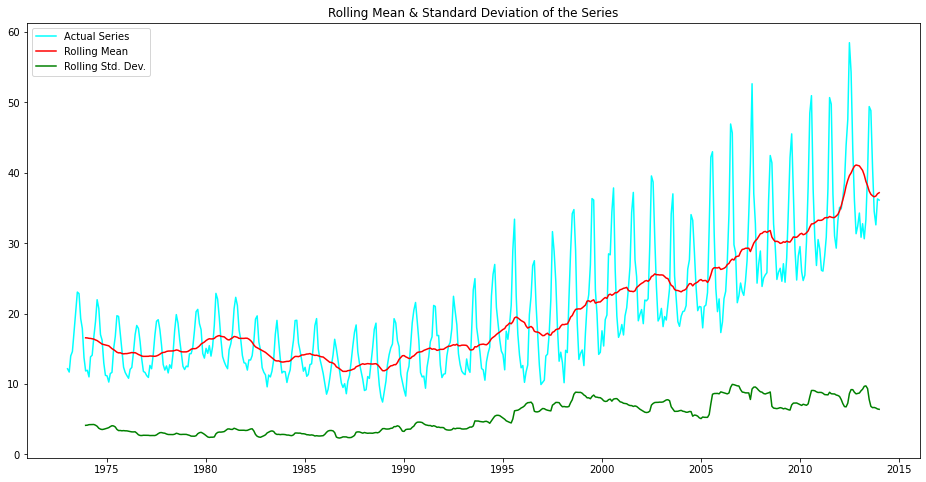

In [15]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean=train_data.rolling(window=12).mean()
rolstd=train_data.rolling(window=12).std()

# Visualize the rolling mean and standard deviation
fig2=plt.figure(figsize=(16,8))
actual = plt.plot(train_data, color='cyan', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()
fig2.savefig("Rolling_mean", bbox_inches='tight', dpi=600)

#### **Observations and Insights: ____**
1. Series has upward trend, it is not stationary
2. The rolling mean does a good job in capturing the avergae trend of the data. However, it fails to capture seasonal patterns in the data.

# **Test the stationarity using the Augmented Dickey-Fuller Test**

Use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

**- Null hypothesis:** The Time Series is non-stationary


**- Alternative hypothesis:** The Time Series is stationary

In [16]:
#Define a function to use adfuller test
def adfuller(train_data):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(train_data['Value'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(train_data)

Dickey-Fuller Test: 
Test Statistic            1.175642
p-value                   0.995813
Lags Used                18.000000
No. of Observations     474.000000
Critical Value (1%)      -3.444221
Critical Value (5%)      -2.867657
Critical Value (10%)     -2.570028
dtype: float64


- **Observations and Insights**
- 1. From the above test, we can see that the p-value = 0.995 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
- 2. Hence, we can confirm that the series is non-stationary.

# **Transformation of the dataset into a stationary one**

**We can use some of the following methods to convert a non-stationary series into a stationary one:**


1. Log Transformation
2. Differencing the series 

We take the average of ‘k’ consecutive values depending on the frequency of time series (in this capstone 12 months). 

Here, we will take the average over the past 1 year.

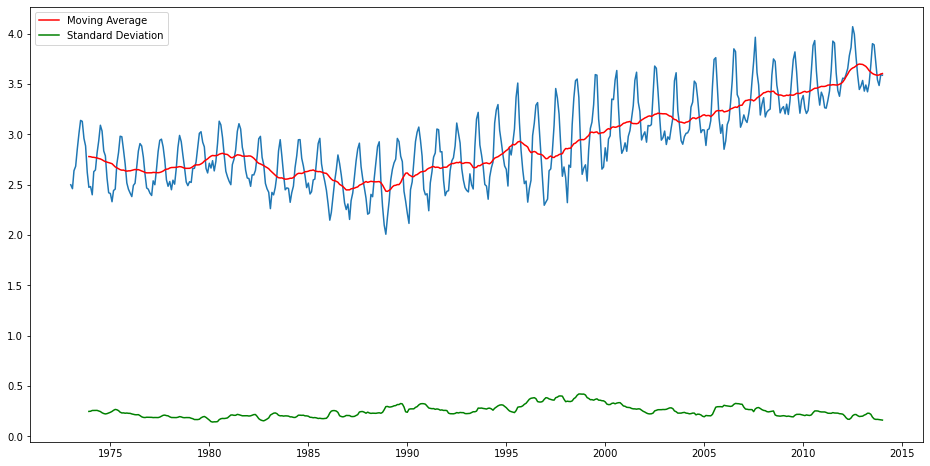

In [17]:
 # Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(train_data) #Reduced variance
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
fig3=plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations and Insights: _____**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same.**

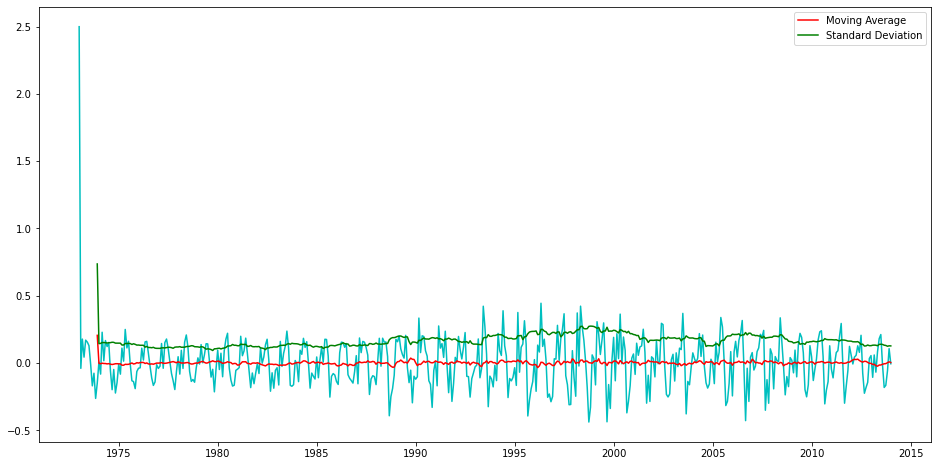

In [18]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1,fill_value=0)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations and Insights:___**
- 1.Since we can no longer see an upward trend, the series seems to be almost constant (stationary)

- 2. The standard deviation also seems to be almost constant

**Lets verify using Augmented Dickey-Fuller (ADF) Test**

In [19]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -6.406790e+00
p-value                 1.934389e-08
Lags Used               1.600000e+01
No. of Observations     4.760000e+02
Critical Value (1%)    -3.444163e+00
Critical Value (5%)    -2.867631e+00
Critical Value (10%)   -2.570014e+00
dtype: float64


**Observations and Insights:**
1. From the above test, we can see that the p-value = 1.93e-8 i.e. < 0.05 (For 95% confidence intervals) therefore, we can reject the null hypothesis.
2. Hence, we can confirm that the series is now stationary.



**Obtaining stationarity through seasonal differencing**

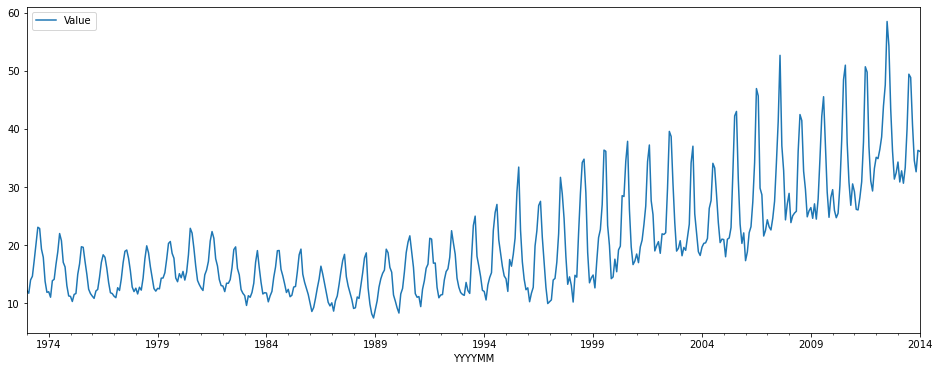

ADF Statistic: 1.1756421374675283
p-value: 0.9958131962670929


In [20]:
from statsmodels.tsa.stattools import adfuller
# implementing ADF test on the original time series data
result = adfuller(train_data['Value'])

fig, ax = plt.subplots(figsize=(16, 6))
train_data.plot(ax=ax)
plt.show()

# printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

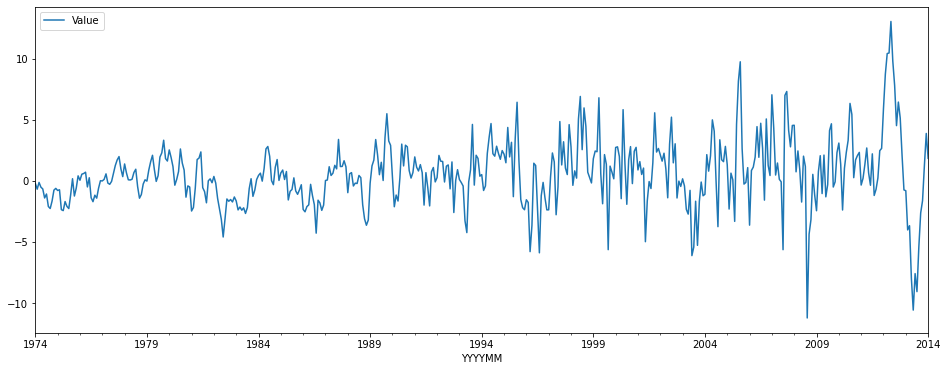

ADF Statistic: -5.467290313205371
p-value: 2.4426965230136158e-06


In [21]:
# taking seasonal differencing of the timeseries
train_data_stationary = train_data.diff(periods=12).dropna()

# implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['Value'])

fig, ax = plt.subplots(figsize=(16, 6))
train_data_stationary.plot(ax=ax)
plt.show()

# printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

#### **Observations and Insights: _____**
1. p-value=2.44e-6<0.05. Stationarity is obtained by 1st order differencing. Therefore D=1 in SARIMA modelling

Let's decompose the time series to check its different components.

### **Elimination of trend and seasonality: Decomposition**

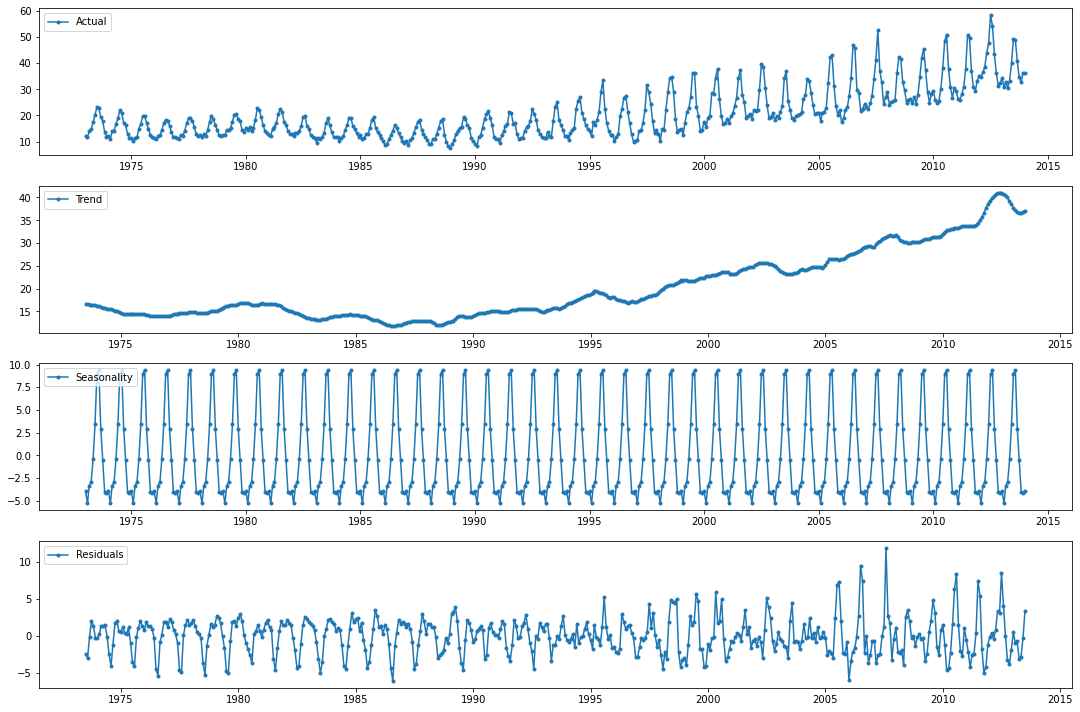

In [22]:
#Importing the seasonal_decompose function to decompose the time series

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(train_data)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_data, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations and Insights: ____**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Natural gas based CO2 emissions spike in July and August.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

**Plot the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models**

### **Find optimal parameters (p,d,q)x(P,D,Q) and build the SARIMA model**

**Plot the ACF and PACF charts and find the optimal parameters**

<Figure size 1152x576 with 0 Axes>

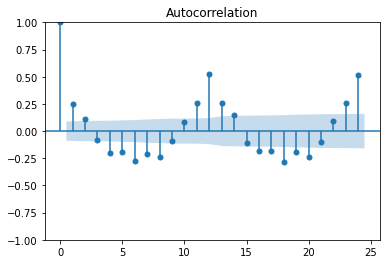

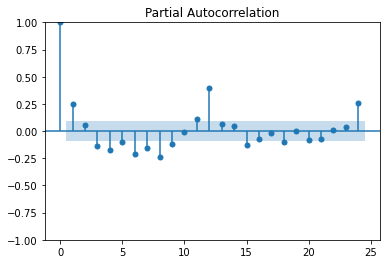

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 24) 
plt.show() 
plot_pacf(df_shift, lags = 24) 
plt.show()

**Observations and Insights: _____**

**Observations:**
- From the above PACF plot we can see that **the lag** at which the plot extends beyond the statistically significant boundary for the first time is **lag 1.** 
- This indicates that **lag 1 (p=1)** should be sufficient to fit the data.
- We observed a periodicity on the PACF since the underlying data is periodic with a period of 12 months. Hence, 'P' which is the order of seasonal AR term in SARIMA model is equal to 1.

- Similarly, from the ACF plot, we can infer that **q=1.**
- The ACF and PACF also capture the seasonality in the data
- We observed a periodicity on the ACF since the underlying data is periodic with a period of 12 months. Hence, 'Q' which is the order of seasonal MA term in SARIMA model is equal to 1.

In [24]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# SARIMA Model

To Fit and predict the shifted series with the SARIMA Model and calculate the RMSE

In [25]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df_log.astype(float),
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,enforce_invertibility=False)

        results = mod.fit(disp=0)

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2463.440370655114
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1810.513348917459
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-613.0915025747271
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-615.7749896700783
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-624.719276424407
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-667.9945746163744
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-618.6959208956696
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-615.7353339943788
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1815.2735626240199
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1209.6421047949862
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-816.9652197049269
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-843.8951426359606
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-825.3303265611797
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-898.953357384377
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-843.5812288781498
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-843.4357563710286
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-382.4604543026962
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-577.8482804361

**Observations**:
1. The (p,d,q)x(P,D,Q) combination that resulted in the least AIC score (-1048.0736) is (1,1,1)x(1,0,1,12). Therefore, this combination is a good starting point for fitting the SARIMA model on the training data.

**Fitting SARIMA model**

-1048.07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6456      0.042     15.556      0.000       0.564       0.727
ma.L1         -1.0692      0.027    -39.187      0.000      -1.123      -1.016
ar.S.L12       0.9916      0.008    131.188      0.000       0.977       1.006
ma.S.L12      -0.7507      0.036    -21.130      0.000      -0.820      -0.681
sigma2         0.0055      0.000     13.197      0.000       0.005       0.006


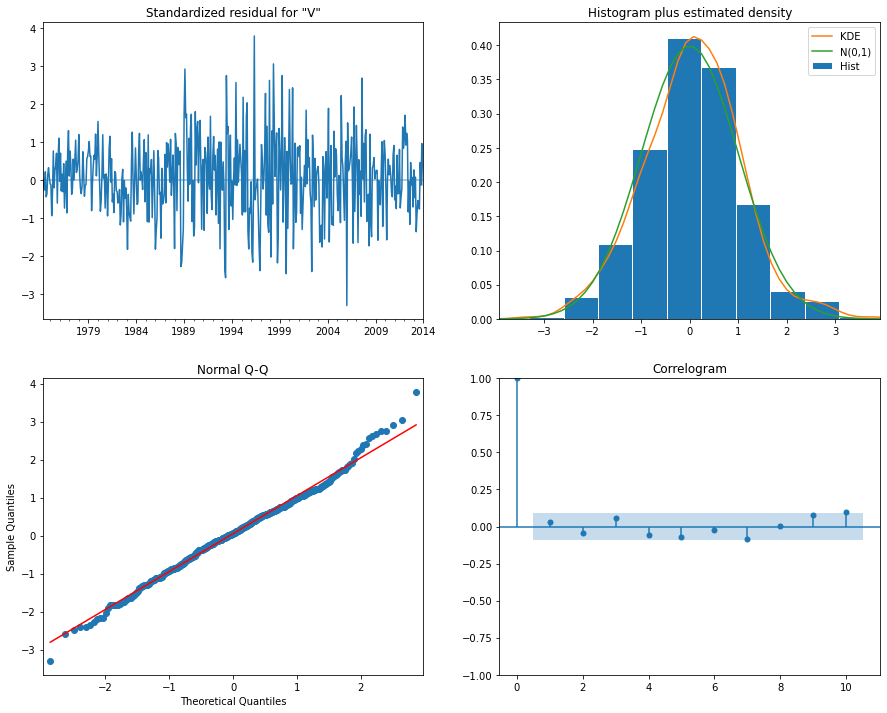

In [27]:
#creating an SARIMA model with parameters (1, 1, 1)x(1, 0, 1, 12)
mod = sm.tsa.statespace.SARIMAX(df_log.astype(float),
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=0)

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Observations:**

Top left: The residual errors seem to fluctuate around a mean of zero.

Top Right: The density plot suggests that the distribution of residuals is very close to a standard normal distribution.

Bottom left: The quantile-quantile plot indicates that the sample quantiles are approximately equal to the theoritical quantiles. Any significant deviations would imply the distribution of residuals is skewed.

Bottom Right: The ACF plot shows the residuals are not autocorrelated as no lag other than 0 is significant. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.

The above plots show that the model assumptions are not violated.

**Inverse Transformation**

**Use the correct inverse transformation depending on the model chosen to get back the original values**

**Apply an inverse transformation on the predictions of the chosen model**

In [28]:
# Printing the fitted values
predictions=pd.Series(results.fittedvalues)
#predictions

In [29]:
#Third step - applying exponential transformation
predictions_SARIMA = np.exp(predictions)#use exponential function
#predictions_SARIMA

**Plot the original vs predicted series of the training data**

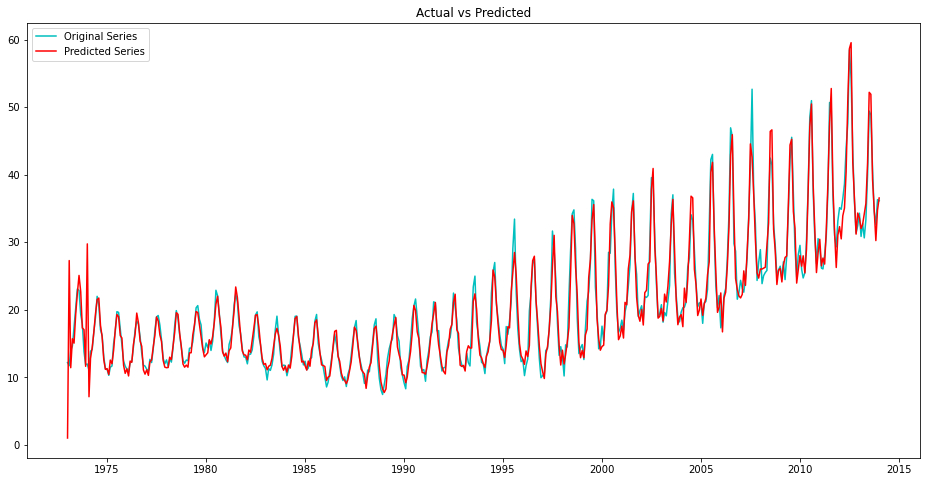

In [30]:
#Code here
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_SARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations & Insights**:  
- We can see that the predicted series is very similar to the original series i.e. The model is good at predicting values on the training data, apart from one outlier prediction in 1974.**
- The seasonal aspect of the SARIMA model helps us better capture the seasonal variations in the data.

# Forecast from 2014 to 2016 to check if the predictions align with the test data

In [31]:
#Add the code blocks based on the requirements
forecasted_SARIMA = results.forecast(steps=31)#forecast using the results_ARIMA for next 31 months. Keep steps=24
forecasted_SARIMA

2014-02-01    3.496672
2014-03-01    3.535454
2014-04-01    3.539997
2014-05-01    3.645940
2014-06-01    3.824101
2014-07-01    4.043972
2014-08-01    4.045744
2014-09-01    3.805018
2014-10-01    3.635261
2014-11-01    3.510004
2014-12-01    3.592412
2015-01-01    3.611557
2015-02-01    3.529242
2015-03-01    3.572514
2015-04-01    3.580129
2015-05-01    3.687192
2015-06-01    3.865156
2015-07-01    4.084021
2015-08-01    4.086318
2015-09-01    3.847959
2015-10-01    3.679851
2015-11-01    3.555789
2015-12-01    3.637600
2016-01-01    3.656645
2016-02-01    3.575059
2016-03-01    3.617995
2016-04-01    3.625562
2016-05-01    3.731738
2016-06-01    3.908217
2016-07-01    4.125250
2016-08-01    4.127531
Freq: MS, Name: predicted_mean, dtype: float64

In [32]:
list2 = forecasted_SARIMA.tolist()
series2 = pd.Series(list2)
#series2

In [33]:
index = pd.date_range('2013-12-01','2016-07-01' , freq='1M')
df2 = pd.DataFrame()
df2['forecasted'] = np.exp(series2)
df2.index = index
#df2

**Plot the original vs predicted series**

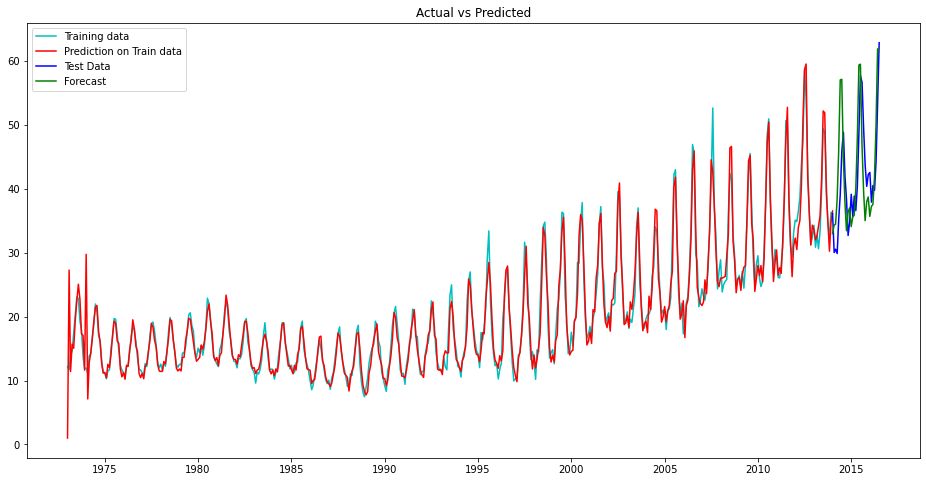

In [34]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Training data')
plt.plot(predictions_SARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(test_data,color='b',label='Test Data')
plt.plot(df2, label = 'Forecast', color='g')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not**

In [35]:
from sklearn.metrics import mean_squared_error
error =np.sqrt(mean_squared_error(predictions_SARIMA, train_data)) #calculate RMSE using the predictions_ARIMA and df_train 
error

2.0953231416109173

In [36]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(forecasted_SARIMA, test_data))
error#calculate RMSE using the forecasted_ARIMA and df_test

38.83372035423802

**Observations and Insights**
1. The above plot shows that the model is able to identify the trend and seasonalities in the data. 
2. The forecasted values are similar to the test data
3. Based on the RMSE values and the plot, it looks like this model is able to capture the trend and seasonal patterns well

**Observations**:
1. The small RMSE values also indicate that this is a good model to forecast CO2 emission values

# Forecast for the next 24 months from original data

-1132.68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6546      0.040     16.464      0.000       0.577       0.733
ma.L1         -0.9371      0.023    -41.005      0.000      -0.982      -0.892
ar.S.L12       0.9890      0.007    132.364      0.000       0.974       1.004
ma.S.L12      -0.7430      0.035    -21.504      0.000      -0.811      -0.675
sigma2         0.0060      0.000     17.760      0.000       0.005       0.007


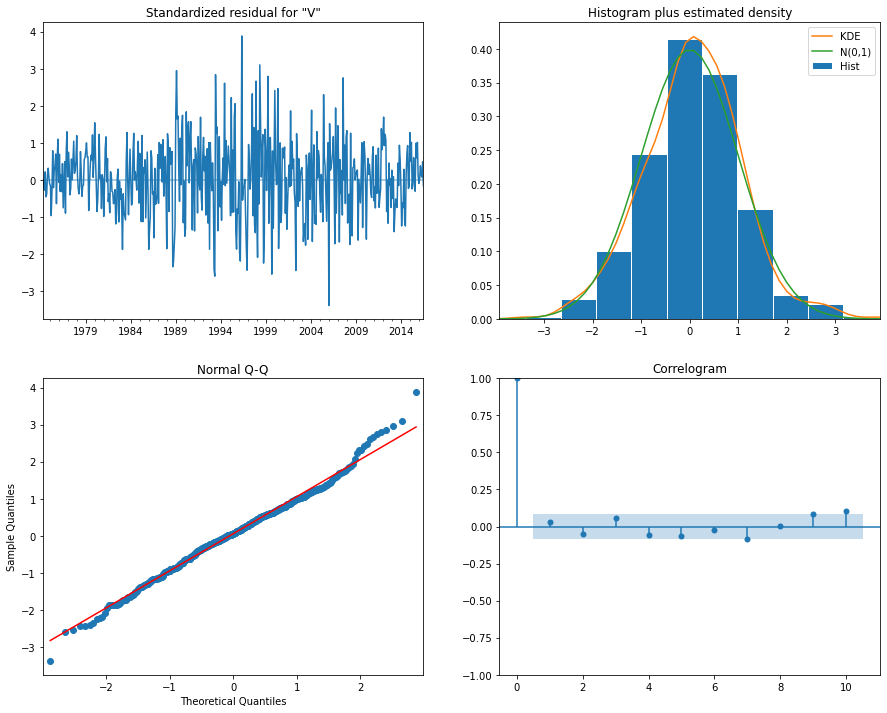

In [37]:
#creating an SARIMA model with parameters (1, 1, 1)x(1, 0, 1, 12)
df_log_original=np.log(natural)
mod_original = sm.tsa.statespace.SARIMAX(df_log_original.astype(float),
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_original = mod_original.fit(disp=0)

print(round(results_original.aic,2))
print(results_original.summary().tables[1])
results_original.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
# Printing the fitted values
predictions_final=pd.Series(results_original.fittedvalues)
#predictions

In [39]:
#Third step - applying exponential transformation
predictions_SARIMA_final = np.exp(predictions_final)#use exponential function
#predictions_SARIMA

In [40]:
#Add the code blocks based on the requirements
forecasted_SARIMA_final = results_original.forecast(steps=48)#forecast using the results_ARIMA for next 24 months. Keep steps=24
#forecasted_SARIMA

In [41]:
list2 = forecasted_SARIMA_final.tolist()
series2 = pd.Series(list2)
#series2

In [42]:
index = pd.date_range('2016-07-02','2020-07-02' , freq='1M')- pd.offsets.MonthBegin(1)
df3 = pd.DataFrame()
df3['forecasted'] = np.exp(series2)
df3.index = index
#df2

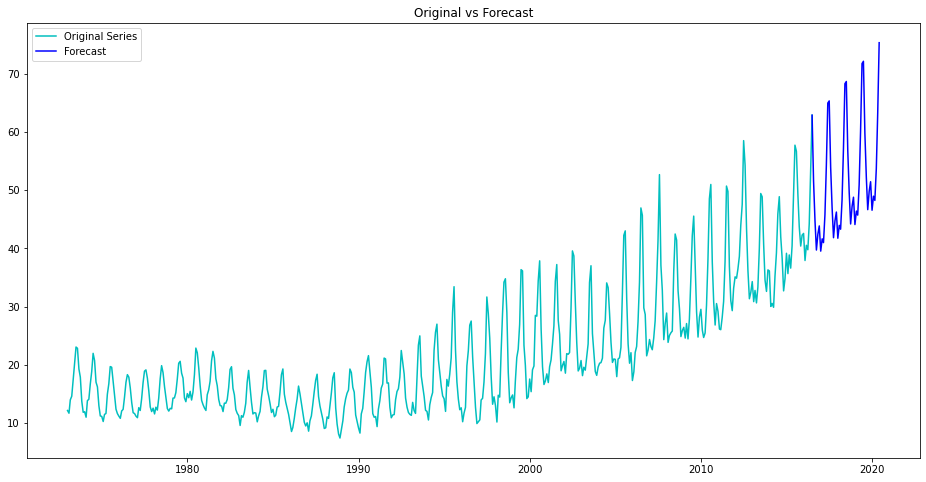

In [43]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(natural, color = 'c', label = 'Original Series')
plt.plot(df3, color = 'b', label = 'Forecast') #plot the predictions_ARIMA series
plt.title('Original vs Forecast')
plt.legend()
plt.show()

**Executive Summary**
1. Upon trying various models such as AR,MA, ARMA and ARIMA to fit the natural gas CO2 emissions data from 1973 to 2016, SARIMA model seems to fit the data very well.
2. This model captures the trend as well as the seasonalities in the dtraining data and and fits well with the test data too
3. The natural gas CO2 emissions forecast fot the next 24 months (2016 to 2018) indicates an upwards trend ans seasonliities eith spikes in July and August every year 

**Problem and Solution Summary**
- 1. The problem in question is to understand how the CO2 emissions due to natural gasconsumption would behave in the future.
- 2. This would potentially help us in designing new energy efficient policies.
- 3. Key solution design points:
    - a. CO2 emissions due to natural gas consumptions in the last 40 years, displays trends and seasonal patterns.The forecasted data should be able to predict such trends and seasonal occurances.
    - b. SARIMA model is able to capture trend and seasonalities. Hence, it is chosen for fitting the time series daata of CO2 emissions due to natural gas consumption
    - The data was split into training data (1973-2014) and test data (2014-2016)
    - c. The SARIMA model was tuned using grid search on the training data, and the metric used to select the best model was AIC. The best model was ARIMA(1,1,1)x(1,0,1,12), AIC: -1048
    - d. Further, the performance of the model was evaluated by plotting the predicted values and comparing to that of the test data using RMSE
    - f. Finally, the forecast for the next 48 months (2016-2020) was obtained using the chosen model. The forecast indicates upward trends and seasonalities with periodic spikes in July and AUgust of every year. 

**Recommendations for Implementation**
- 1. Co2 emissions maybe influenced by numerous other features in addition to using lagged values. Hence, a supplemental analysis done by identifying with stakeholders key drivers and improving model forecasts would be an immediate next step
- 2. Forecasts may be used to assess environmental/health costs and used as a lever to justify increased investments in renewable energy like solar, wind etc
- 3. A key risk in implementation is regional/geographical variation in Co2 behaviour. This study may need to be done acroos multiple geographies to justify investment in renewable sources
- 4. A cost/benefit analysis maybe done using the forecasts. What is the cost of reducing natural gas CO2 emissions? Would the benefit gained by shifting to other sources outweigh the short term cost of shifting sources?